In [161]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive
from pathlib import Path
import h5py
from tqdm  import tqdm
from maf_gp import model, model_n, cov_matrix_emulator, prior_predict, posterior_predict
jax.config.update("jax_enable_x64", True)
matplotlib.rcParams["axes.formatter.limits"] = [-4,4]
matplotlib.rcParams["font.size"] = 14
matplotlib.rcParams["font.family"] = 'sans-serif'

## Prepare data and posterior samples

In [162]:
# path of file of posterior samples (need to change for the file of saved posterior samples)
file_path = Path("results_mcmc/bias_alpha_hv_90_135_2023_11_14_21_25_53_MAF_linear.h5")
f = h5py.File(file_path, 'r')

# path of data folder (need to change for horizontal prediction or vertical prediction)
data_path = Path("data_extension_h")
# data for which loading angles to use (need to change according to requirement)
angles = [90, 135] 
# loading angle need to predict
angle_value = 45
# figure format, dpi
fig_format = 'webp'
dpi = 200
# folder to save figures etc.
if len(angles) == 3:
    fig_path = Path("figures_bias_alpha")
else:
    fig_path = Path("figures_bias_alpha_leave_out")

fig_path.mkdir(exist_ok=True)

# direction
direction = data_path.stem[-1]

# experimental data
input_xy_exp_l = []
data_exp_l = []
for file_load_angle, file_ext in zip( sorted(data_path.glob("input_load_angle_exp_*")),
                sorted(data_path.glob("data_extension_exp_*")) ):
    load_angle = np.loadtxt(file_load_angle, delimiter=",")
    if (np.abs(np.rad2deg(load_angle[0,1]) - np.array(angles)) < 1e-6).any():
        input_xy_exp_l.append(load_angle)
        data_exp_l.append(np.loadtxt(file_ext, delimiter=",").mean(axis=1))

if len(input_xy_exp_l) > 0: 
    input_xy_exp = jnp.concatenate(input_xy_exp_l, axis=0)
    data_exp = jnp.concatenate(data_exp_l, axis=0)
    
num_exp = len(input_xy_exp_l)
data_size_exp = [i.shape[0] for i in input_xy_exp_l]

# experiment date for the prediction loading angle
input_xy_exp_plt = []
data_exp_plt = []
for file_load_angle, file_ext in zip( sorted(data_path.glob("input_load_angle_exp_*")),
                             sorted(data_path.glob("data_extension_exp_*")) ):
    load_angle = np.loadtxt(file_load_angle, delimiter=",")
    if np.abs(np.rad2deg(load_angle[0,1]) - angle_value) < 1e-6:
        input_xy_exp_plt.append(load_angle)
        data_exp_plt.append(np.loadtxt(file_ext, delimiter=",").mean(axis=1))    

# simulation data
input_xy_sim = jnp.array(np.loadtxt(data_path / "input_load_angle_sim.txt", delimiter=","))
input_theta_sim = jnp.array(np.loadtxt(data_path / "input_theta_sim.txt", delimiter=","))
data_sim = jnp.array(np.loadtxt(data_path / "data_extension_sim.txt", delimiter=",")).mean(axis=1)


## Plot prior and posterior distributions

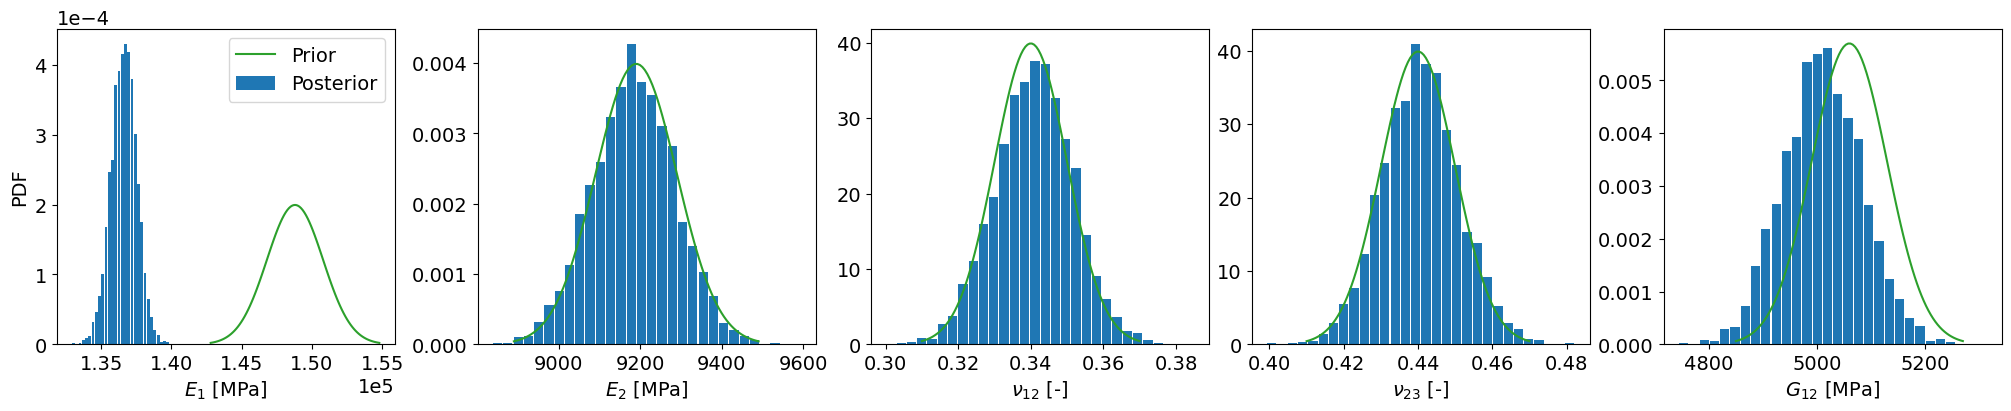

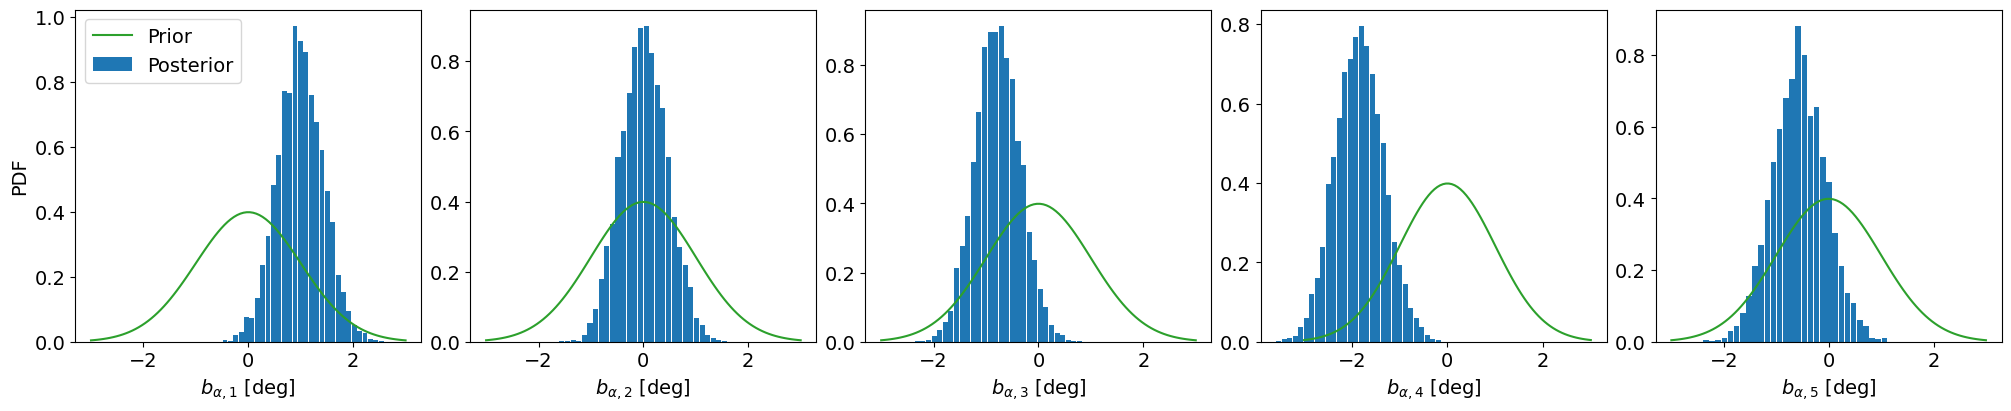

In [163]:
prior_dist = [] 
prior_dist.append(dist.Normal(148800, 2000))
prior_dist.append(dist.Normal(9190, 100))
prior_dist.append(dist.Normal(0.34, 0.01))
prior_dist.append(dist.Normal(0.44, 0.01))
prior_dist.append(dist.Normal(5060, 70))

# FE model parameters
keys = ['E_1', 'E_2', 'v_12', 'v_23', 'G_12']
x_labels = ['$E_1$ [MPa]', '$E_2$ [MPa]', '$\\nu_{12}$ [-]', '$\\nu_{23}$ [-]', '$G_{12}$ [MPa]'] 
dic_0 = {}
dic = {}
fig, ax = plt.subplots(nrows=1, ncols=len(keys), figsize=(20,4), layout='constrained')
for i in range(len(keys)):
    dic_0[x_labels[i]] = f[keys[i]] 
    dic[x_labels[i]] = f[keys[i]][::3]
    # fig, ax = plt.subplots()
    x_prior = jnp.linspace(prior_dist[i].mean - 3 * prior_dist[i].variance**(0.5), 
                           prior_dist[i].mean + 3 * prior_dist[i].variance**(0.5), 100)
    ax[i].plot(x_prior, jnp.exp(prior_dist[i].log_prob(x_prior)), color='tab:green', lw=1.5,  label='Prior')   
    ax[i].hist(f[keys[i]], bins=30, rwidth=0.9, color='tab:blue', density=True, label='Posterior')
    ax[i].set_xlabel(x_labels[i])
    if i == 0:
        ax[i].set_xticks(np.arange(1.35, 1.60, 0.05) * 1e5)
        ax[i].set_ylabel("PDF")
        ax[i].legend()
    # ax[i].ticklabel_format(scilimits=(-5,5))
# fig.tight_layout()

if len(angles) == 3:
    suffix = data_path.stem[-1]
else:
    suffix = data_path.stem[-1]
    for i in angles:
        suffix = suffix + '_' + str(i)

fig.savefig(fig_path.joinpath("inference_theta_linear_bias_alpha" + suffix[1:] + "." + fig_format), 
            dpi=dpi, transparent=True)

df_0 = pd.DataFrame(dic_0)
post_stats = {"mean": df_0.mean(),
             "variance": df_0.var(),
             "std": df_0.std()}
pd.concat(post_stats, axis=1).to_csv(fig_path.joinpath("inference_theta_linear_bias_alpha_stats" + suffix[1:] + ".csv"))

# df = pd.DataFrame(dic)
# # df.columns = x_labels
# grid = sns.pairplot(df, kind='scatter', diag_kind='hist')
# grid.savefig("inference_theta_grid_linear_bias_alpha_" + suffix + "." + fig_format, dpi=dpi, transparent=True)

keys_b = []
x_labels_b = []
dic_b = {}
for i in range(len(input_xy_exp_l)):
    keys_b.append("b_"+str(i+1)+"_alpha")
    x_labels_b.append("$b_{\\alpha,"+str(i+1)+"}$ [deg]")
    dic_b["$b_{\\alpha,"+str(i+1)+"}$ [deg]"] = np.rad2deg(f[keys_b[i]]) # to degree

if len(angles) < 3:
    fig_b, ax_b = plt.subplots(nrows=1, ncols=len(keys_b), figsize=(len(keys_b)*4, 4), layout='constrained')
    for i in range(len(keys_b)):
        # fig, ax = plt.subplots()
        x_prior = np.linspace(-3, 3, 100)
        ax_b[i].plot(x_prior, np.exp(dist.Normal(0,1).log_prob(x_prior)), color='tab:green', lw=1.5, label='Prior')   
        ax_b[i].hist(np.rad2deg(f[keys_b[i]]), bins=30, rwidth=0.9, color='tab:blue', density=True, label='Posterior')
        ax_b[i].set_xlabel(x_labels_b[i])
        if i == 0:
            ax_b[i].legend()
            ax_b[i].set_ylabel("PDF")

    # fig_b, ax_b = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), layout='constrained')
    # for i in range(2):
    #     for j in range(4):
    #         # fig, ax = plt.subplots()
    #         x_prior = np.linspace(-3, 3, 100)
    #         ax_b[i,j].plot(x_prior, np.exp(dist.Normal(0,1).log_prob(x_prior)), color='tab:green', lw=1.5, label='Prior')   
    #         ax_b[i,j].hist(np.rad2deg(f[keys_b[i*4+j]]), bins=30, rwidth=0.9, color='tab:blue', density=True, label='Posterior')
    #         ax_b[i,j].set_xlabel(x_labels_b[i*4+j])
    #         # ax[i,j].ticklabel_format(scilimits=(-5,5))
    #         if i==0 and j==0:
    #             ax_b[i,j].legend()
    #             ax_b[i,j].set_ylabel("PDF")
    #         if i==1 and j==0:
    #             ax_b[i,j].set_ylabel("PDF")
else:
    fig_b, ax_b = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), layout="constrained")
    for i in range(3):
        for j in range(3):
            if i==2 and j==2:
                ax_b[i,j].set_axis_off()
                break
            x_prior = np.linspace(-3, 3, 100)
            ax_b[i,j].plot(x_prior, np.exp(dist.Normal(0,1).log_prob(x_prior)), color='tab:green', lw=1.5, label='Prior')
            ax_b[i,j].hist(np.rad2deg(f[keys_b[i*3+j]]), bins=30, rwidth=0.9, color='tab:blue', density=True, label='Posterior')
            ax_b[i,j].set_xlabel(x_labels_b[i*3+j])
            if i==0 and j==0:
                ax_b[i,j].legend()
                ax_b[i,j].set_ylabel("PDF")
            if (i==1 or i==2) and j==0:
                ax_b[i,j].set_ylabel("PDF")

df_b = pd.DataFrame(dic_b)
post_stats_b = {"mean": df_b.mean(),
                "variance": df_b.var(),
                "std": df_b.std()}
pd.concat(post_stats_b, axis=1).to_csv(fig_path.joinpath("inference_b_linear_bias_E1_stats" + suffix[1:] + ".csv"))

fig_b.savefig(fig_path.joinpath("inference_b_linear_bias_alpha" + suffix[1:] + "." + fig_format), 
              dpi=dpi, transparent=True)
# f.close()

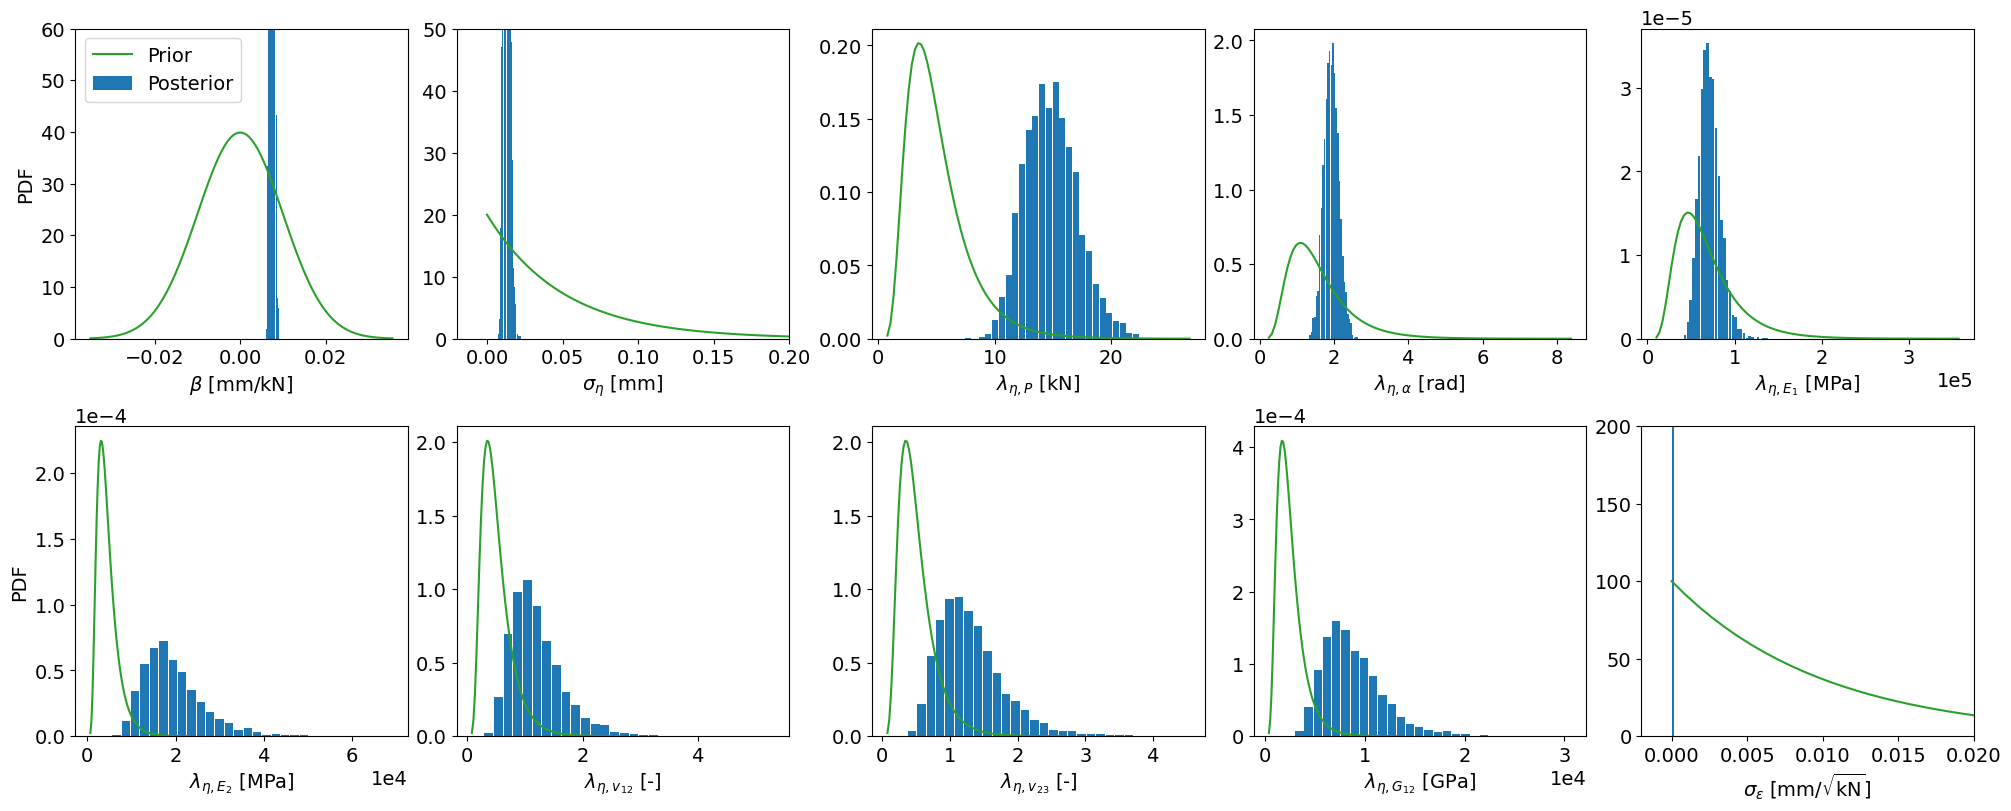

In [164]:
prior_dist_hyper = [] 
prior_dist_hyper.append(dist.Normal(0, 0.01))
prior_dist_hyper.append(dist.Exponential(20.))
prior_dist_hyper.append(dist.LogNormal(1.5, 0.5))
prior_dist_hyper.append(dist.LogNormal(0.34, 0.5))
prior_dist_hyper.append(dist.LogNormal(11., 0.5))
prior_dist_hyper.append(dist.LogNormal(8.3, 0.5))
prior_dist_hyper.append(dist.LogNormal(-0.80, 0.5))
prior_dist_hyper.append(dist.LogNormal(-0.80, 0.5))
prior_dist_hyper.append(dist.LogNormal(7.7, 0.5))
prior_dist_hyper.append(dist.Exponential(100.))

# hyper-parameters
keys_hyper = ['mu_emulator', 'sigma_emulator', 'lambda_P', 'lambda_alpha', 'lambda_E1', 
              'lambda_E2', 'lambda_v12', 'lambda_v23', 'lambda_G12', 'sigma_measure']
x_labels_hyper = ['$\\beta$ [mm/kN]', '$\sigma_{\eta}$ [mm]', '$\lambda_{\eta,P}$ [kN]', '$\lambda_{\eta,\\alpha}$ [rad]', 
                  '$\lambda_{\eta,E_1}$ [MPa]', '$\lambda_{\eta,E_2}$ [MPa]', '$\lambda_{\eta,v_{12}}$ [-]', '$\lambda_{\eta,v_{23}}$ [-]', 
                  '$\lambda_{\eta,G_{12}}$ [GPa]', '$\sigma_{\epsilon}$ [mm/$\sqrt{\mathrm{kN}}$]']
dic_hyper_0 = {}
dic_hyper = {}
fig_hyper, ax_hyper = plt.subplots(nrows=2, ncols=5, figsize=(20,8), layout='constrained')
for i in range(2):
    for j  in range(5):
        dic_hyper_0[x_labels_hyper[i*5+j]] = f[keys_hyper[i*5+j]]
        dic_hyper[x_labels_hyper[i*5+j]] = f[keys_hyper[i*5+j]][::3]
        # fig, ax = plt.subplots()
        samples_prior = prior_dist_hyper[i*5+j].sample(random.PRNGKey(0), (5000,))
        x_prior = jnp.linspace(samples_prior.min(), samples_prior.max(), 100)
        ax_hyper[i,j].plot(x_prior, jnp.exp(prior_dist_hyper[i*5+j].log_prob(x_prior)), color='tab:green', lw=1.5, label='Prior')  
        ax_hyper[i,j].hist(f[keys_hyper[i*5+j]], bins=30, rwidth=0.9, color='tab:blue', density=True, label='Posterior')
        ax_hyper[i,j].set_xlabel(x_labels_hyper[i*5+j])
        if i==0 and j==0:
            ax_hyper[i,j].legend(loc='upper left')
            ax_hyper[i,j].set_ylabel("PDF")
        if i==1 and j==0:
            ax_hyper[i,j].set_ylabel("PDF")
        if i*5+j == 0:
            ax_hyper[i,j].set_ylim([0,60])
        if i*5+j == 1:
            ax_hyper[i,j].set_ylim([0,50])
            ax_hyper[i,j].set_xlim([-0.02,0.2])
        if i*5+j == 9:
            ax_hyper[i,j].set_ylim([0,200])
            ax_hyper[i,j].set_xlim([-0.002,0.02])
        # ax[i].ticklabel_format(scilimits=(-5,5))
# fig_hyper.tight_layout()

fig_hyper.savefig(fig_path.joinpath("inference_hyper_linear_bias_alpha" + suffix[1:] + "." + fig_format), 
                  dpi=dpi, transparent=True)
    
df_hyper_0 = pd.DataFrame(dic_hyper_0)
post_stats_hyper = {"mean": df_hyper_0.mean(),
                     "variance": df_hyper_0.var(),
                   "std": df_hyper_0.std()}
pd.concat(post_stats_hyper, axis=1).to_csv(fig_path.joinpath("inference_hyper_linear_bias_E1_stats" + suffix[1:] + ".csv"))

# df_hyper = pd.DataFrame(dic_hyper)
# # df_hyper.columns = x_labels_hyper
# grid_hyper = sns.pairplot(df_hyper)
# grid_hyper.savefig("inference_hyper_grid_linear_bias_alpha_" + suffix + "." + fig_format, dpi=dpi, transparent=True)


## Prior prediction

In [165]:
## prior prediction
# angle_value = 135 # 3*jnp.pi/4
n_loads = 100
samples_load = jnp.linspace(0,10,n_loads)
samples_angle = jnp.ones(n_loads) * jnp.deg2rad(angle_value)
test_xy_0 = jnp.stack((samples_load, samples_angle), axis=1)

prior = Predictive(model_n, num_samples=5000)(
    random.PRNGKey(12345), input_xy_exp_l, input_xy_sim, input_theta_sim, data_exp_l, data_sim, add_bias_alpha=True
)
rng_key, rng_key_predict = random.split(random.PRNGKey(123))

# post samples of FE parameters
keys = ['E_1', 'E_2', 'v_12', 'v_23', 'G_12']
samples_prior_theta = []
for key in keys:
    samples_prior_theta.append(prior[key])

samples_prior_theta = jnp.stack(samples_prior_theta, axis=1)

samples_prior_mean_emulator = prior['mu_emulator']
samples_prior_stdev_emulator = prior['sigma_emulator']

samples_prior_length_xy = []
keys = ['lambda_P', 'lambda_alpha']
for key in keys:
    samples_prior_length_xy.append(prior[key])

samples_prior_length_xy = jnp.stack(samples_prior_length_xy, axis=1)

samples_prior_length_theta = []
keys = ['lambda_E1', 'lambda_E2', 'lambda_v12', 'lambda_v23', 'lambda_G12']
for key in keys:
    samples_prior_length_theta.append(prior[key])

samples_prior_length_theta = jnp.stack(samples_prior_length_theta, axis=1)

rng_keys_predict = random.split(rng_key_predict, samples_prior_theta.shape[0])
rng_keys = random.split(rng_key, samples_prior_theta.shape[0])

means_prior, stdevs_prior, predictions_prior = [], [], []
# import time
# start = time.time()
# for ind in range(samples_prior_theta.shape[0]):
for ind in tqdm(range(samples_prior_theta.shape[0])):
    rng_key = rng_keys_predict[ind]
    test_theta = samples_prior_theta[ind]
    mean_emulator = samples_prior_mean_emulator[ind]
    stdev_emulator = samples_prior_stdev_emulator[ind]
    length_xy = samples_prior_length_xy[ind]
    length_theta = samples_prior_length_theta[ind]
    test_xy = test_xy_0.at[:,1].add(dist.Normal(0,np.deg2rad(1)).sample(rng_keys[ind])) # add bias
    # test_xy = test_xy_0.at[:,1].add(dist.Normal(0,dist.Exponential(1/np.deg2rad(1)).sample(rng_keys[ind])).sample(rng_keys[ind])) # add bias
    
    mean, stdev, prediction = prior_predict(rng_key, input_xy_sim, input_theta_sim, data_sim, test_xy, test_theta, 
                                            mean_emulator, stdev_emulator, length_xy, length_theta, direction=direction)
    means_prior.append(mean)
    stdevs_prior.append(stdev)
    predictions_prior.append(prediction)
    
    # if (ind+1)%500 == 0:
    #     print(f"#Iteration: {ind+1}")
# print(time.time() - start)
means_prior = jnp.stack(means_prior, axis=0)
stdevs_prior = jnp.stack(stdevs_prior, axis=0)
predictions_prior = jnp.stack(predictions_prior, axis=0)

mean_prediction_prior = np.mean(means_prior, axis=0)
percentiles_prior = np.percentile(predictions_prior, [2.5, 97.5], axis=0)


100%|██████████| 5000/5000 [04:15<00:00, 19.56it/s]


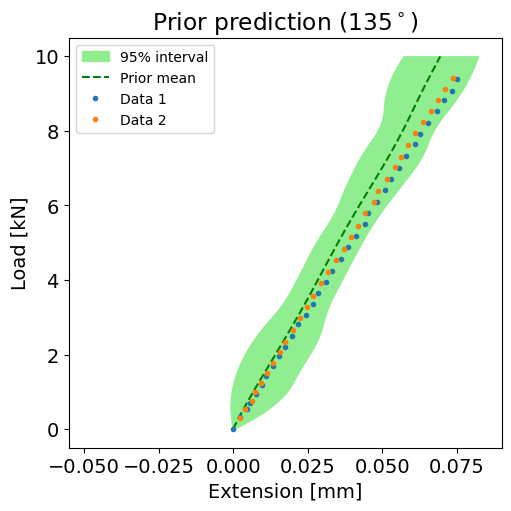

In [166]:
percentiles_prior = np.percentile(predictions_prior, [2.5, 97.5], axis=0)

# stdevs_prior_total = np.sqrt(np.mean(stdevs_prior**2 , axis=0) + np.var(means_prior, axis=0))
# percentiles_prior[0] = np.mean(means_prior, axis=0) - 2*stdevs_prior_total
# percentiles_prior[0] = np.clip(percentiles_prior[0], a_min=0, a_max=None)
# percentiles_prior[1] = np.mean(means_prior, axis=0) + 2*stdevs_prior_total

from scipy.interpolate import make_interp_spline
gap = 8
n_neg = (percentiles_prior[0] < 0.008).sum()
if direction == 'v' and angle_value == 90:
    n_neg = 1

if direction != 'v' or angle_value != 135:
    x = np.concatenate((samples_load[:n_neg:n_neg], samples_load[n_neg::gap]))
    y = np.concatenate((percentiles_prior[0][:n_neg:n_neg], percentiles_prior[0][n_neg::gap]))
    bspl = make_interp_spline(x, y, k=2)
    percentiles_prior[0] = bspl(samples_load)
    bspl = make_interp_spline(samples_load[::gap], percentiles_prior[1][::gap], k=2)
    percentiles_prior[1] = bspl(samples_load)
else:
    n_neg = (percentiles_prior[1] > -0.005).sum()
    x = np.concatenate((samples_load[:n_neg:n_neg], samples_load[n_neg::gap]))
    y = np.concatenate((percentiles_prior[1][:n_neg:n_neg], percentiles_prior[1][n_neg::gap]))
    bspl = make_interp_spline(x, y, k=2)
    # bspl = make_interp_spline(samples_load[::gap], percentiles_prior[1][::gap], k=2)
    percentiles_prior[1] = bspl(samples_load)
    bspl = make_interp_spline(samples_load[::gap], percentiles_prior[0][::gap], k=2)
    percentiles_prior[0] = bspl(samples_load)

df_prior = pd.DataFrame()
df_prior['samples_load'] = samples_load
df_prior['percentiles_prior_l'] = percentiles_prior[0, :]
df_prior['percentiles_prior_u'] = percentiles_prior[1, :]
df_prior['mean_prediction_prior'] = mean_prediction_prior
df_prior.to_csv(fig_path.joinpath("prior_prediction_"+str(angle_value)+"deg_linear_bias_alpha_" + suffix +".csv"))

# make plots
fig_prior, ax_prior = plt.subplots(figsize=(5,5), constrained_layout=True)

# plot 95% confidence level of predictions
ax_prior.fill_betweenx(samples_load, percentiles_prior[0, :], percentiles_prior[1, :], color="lightgreen", label='95% interval')
# plot mean prediction
ax_prior.plot(mean_prediction_prior, samples_load, "green", ls="dashed", lw=1.5, label='Prior mean')
# plot data
sz = 3
for i in range(len(input_xy_exp_plt)):
    ax_prior.plot(data_exp_plt[i], input_xy_exp_plt[i][:,0], "o", markersize=sz, label='Data '+str(i+1))
    
ax_prior.set(xlabel="Extension [mm]", ylabel="Load [kN]", title="Prior prediction ($" + str(angle_value) + "^\circ$)")
ax_prior.legend(fontsize=10)
if angle_value == 45:
    ax_prior.set_xlim(-0.005, 0.09)
if angle_value == 90:
    ax_prior.set_xlim(-0.02, 0.125)
if angle_value == 135:
    ax_prior.set_xlim(-0.055, 0.09)
fig_prior.savefig(fig_path.joinpath("prior_prediction_"+str(angle_value)+"deg_linear_bias_alpha_" + suffix + "." + fig_format),
                  dpi=dpi, transparent=True)
# fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
# for i in range(500):
#     ax.plot(predictions_prior[i], samples_load, alpha=0.5)

## Posterior prediction

In [167]:
# posterior prediction
rng_key, rng_key_predict = random.split(rng_key_predict)

# post samples of FE parameters
keys = ['E_1', 'E_2', 'v_12', 'v_23', 'G_12']
samples_post_theta = []
for key in keys:
    samples_post_theta.append(jnp.array(f[key]))

samples_post_theta = jnp.stack(samples_post_theta, axis=1)

samples_post_mean_emulator = jnp.array(f['mu_emulator'])
samples_post_stdev_emulator = jnp.array(f['sigma_emulator'])

samples_post_length_xy = []
keys = ['lambda_P', 'lambda_alpha']
for key in keys:
    samples_post_length_xy.append(jnp.array(f[key]))

samples_post_length_xy = jnp.stack(samples_post_length_xy, axis=1)

samples_post_length_theta = []
keys = ['lambda_E1', 'lambda_E2', 'lambda_v12', 'lambda_v23', 'lambda_G12']
for key in keys:
    samples_post_length_theta.append(jnp.array(f[key]))

samples_post_length_theta = jnp.stack(samples_post_length_theta, axis=1)

samples_post_stdev_measure = jnp.array(f['sigma_measure'])

rng_keys_predict = random.split(rng_key_predict, samples_post_theta.shape[0])
rng_keys = random.split(rng_key, samples_post_theta.shape[0])

means_post, stdevs_post, predictions_post = [], [], []
for ind in tqdm(range(samples_post_theta.shape[0])):
    rng_key = rng_keys_predict[ind]
    test_theta = samples_post_theta[ind]
    mean_emulator = samples_post_mean_emulator[ind]
    stdev_emulator = samples_post_stdev_emulator[ind]
    length_xy = samples_post_length_xy[ind]
    length_theta = samples_post_length_theta[ind]
    stdev_measure = samples_post_stdev_measure[ind]
    test_xy = test_xy_0.at[:,1].add(dist.Normal(0,np.deg2rad(1)).sample(rng_keys[ind])) # add bias
    # test_xy = test_xy_0.at[:,1].add(dist.Normal(0,f['sigma_b_alpha'][ind]).sample(rng_keys[ind])) # add bias
    
    input_xy_exp_b = []
    for i in range(num_exp):
        input_xy_exp_b.append( jnp.array(input_xy_exp_l[i]) + 
                              jnp.concatenate((jnp.zeros((data_size_exp[i],1)), 
                                               jnp.array(f["b_"+str(i+1)+"_alpha"][ind])*jnp.ones((data_size_exp[i],1))), axis=1) )
    input_xy_exp = jnp.concatenate(input_xy_exp_b, axis=0)
    input_xy_exp = jnp.concatenate(input_xy_exp_l, axis=0)
    
    input_theta_exp = jnp.tile(test_theta, (input_xy_exp.shape[0],1))
    
    mean, stdev, prediction = posterior_predict(rng_key, input_xy_exp, input_xy_sim, input_theta_exp, input_theta_sim, data_exp, data_sim,
                                      test_xy, test_theta, mean_emulator, stdev_emulator, length_xy, length_theta, stdev_measure, direction=direction)
    # mean, stdev, prediction = prior_predict(rng_key, input_xy_sim, input_theta_sim, data_sim, test_xy, test_theta, 
    #                                         mean_emulator, stdev_emulator, length_xy, length_theta, direction=direction)
    
    means_post.append(mean)
    stdevs_post.append(stdev)
    predictions_post.append(prediction)
    
    # if (ind+1)%500 == 0:
    #     print(f"#Iteration: {ind+1}")

means_post = jnp.stack(means_post, axis=0)
stdevs_post = jnp.stack(stdevs_post, axis=0)
predictions_post = jnp.stack(predictions_post, axis=0)

mean_prediction_post = np.mean(predictions_post, axis=0)
percentiles_post = np.percentile(predictions_post, [2.5, 97.5], axis=0)


 22%|██▏       | 1076/5000 [01:14<04:33, 14.35it/s]

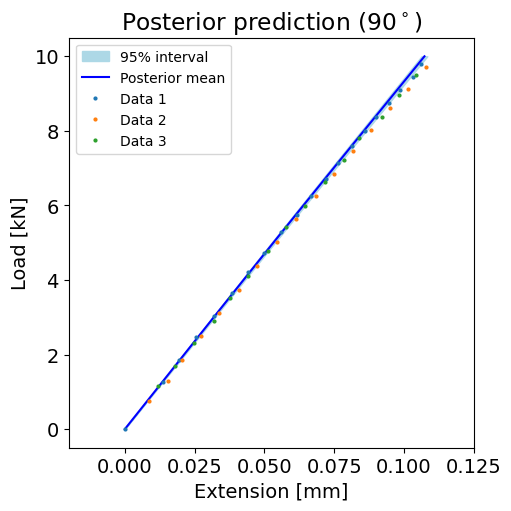

In [ ]:
df_post = pd.DataFrame()
df_post['samples_load'] = samples_load
df_post['percentiles_post_l'] = percentiles_post[0, :]
df_post['percentiles_post_u'] = percentiles_post[1, :]
df_post['mean_prediction_post'] = mean_prediction_post
df_post.to_csv(fig_path.joinpath("post_prediction_"+str(angle_value)+"deg_linear_bias_alpha_" + suffix +".csv"))

# make plots
fig_post, ax_post = plt.subplots(figsize=(5,5), constrained_layout=True)

# plot 90% confidence level of predictions
ax_post.fill_betweenx(samples_load, percentiles_post[0, :], percentiles_post[1, :], color="lightblue", label="95% interval")
# plot mean prediction
ax_post.plot(mean_prediction_post, samples_load, "blue", ls="solid", lw=1.5, label="Posterior mean")
# plot data
sz=2
for i in range(len(input_xy_exp_plt)):
    ax_post.plot(data_exp_plt[i], input_xy_exp_plt[i][:,0], "o", markersize=sz, label='Data '+str(i+1))

ax_post.set(xlabel="Extension [mm]", ylabel="Load [kN]", title="Posterior prediction ($" + str(angle_value) + "^\circ$)")
ax_post.legend(fontsize=10)
if angle_value == 45:
    ax_post.set_xlim(-0.005, 0.09)
if angle_value == 90:
    ax_post.set_xlim(-0.02, 0.125)
if angle_value == 135:
    ax_post.set_xlim(-0.055, 0.09)
fig_post.savefig(fig_path.joinpath("post_prediction_"+str(angle_value)+"deg_linear_bias_alpha_" + suffix + "." + fig_format), 
                 dpi=dpi, transparent=True)


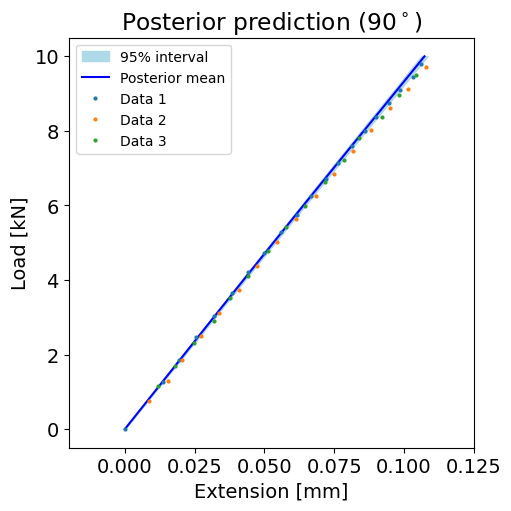

In [ ]:
samples_post_stdevs = np.sqrt(samples_post_stdev_measure[:,None]**2 * samples_load)
# samples_post_stdevs = (samples_post_stdev_measure[:,None] * samples_load)

measure_error = np.random.randn(*samples_post_stdev_measure.shape)[:,None] * samples_post_stdevs
predictions_post_error = predictions_post + measure_error
mean_prediction_post_error = np.mean(predictions_post_error, axis=0)
percentiles_post_error = np.percentile(predictions_post_error, [2.5, 97.5], axis=0)

df_post_error = pd.DataFrame()
df_post_error['samples_load'] = samples_load
df_post_error['percentiles_post_error_l'] = percentiles_post_error[0, :]
df_post_error['percentiles_post_error_u'] = percentiles_post_error[1, :]
df_post_error['mean_prediction_post_error'] = mean_prediction_post_error
df_post_error.to_csv(fig_path.joinpath("post_prediction_error_"+str(angle_value)+"deg_linear_bias_alpha_" + suffix +".csv"))

# make plots
fig_post2, ax_post2 = plt.subplots(figsize=(5,5), layout='constrained')

# plot 90% confidence level of predictions
ax_post2.fill_betweenx(samples_load, percentiles_post_error[0, :], percentiles_post_error[1, :], color="lightblue", label="95% interval")
# plot mean prediction
ax_post2.plot(mean_prediction_post_error, samples_load, "blue", ls="solid", lw=1.5, label="Posterior mean")
# plot data
sz=2
for i in range(len(input_xy_exp_plt)):
    ax_post2.plot(data_exp_plt[i], input_xy_exp_plt[i][:,0], "o", markersize=sz, label='Data '+str(i+1))

ax_post2.set(xlabel="Extension [mm]", ylabel="Load [kN]", title="Posterior prediction ($" + str(angle_value) + "^\circ$)")
ax_post2.legend(fontsize=10)
if angle_value == 45:
    ax_post2.set_xlim(-0.005, 0.09)
if angle_value == 90:
    ax_post2.set_xlim(-0.02, 0.125)
if angle_value == 135:
    ax_post2.set_xlim(-0.055, 0.09)
fig_post2.savefig(fig_path.joinpath("post_prediction_error_"+str(angle_value)+"deg_linear_bais_alpha_" + suffix + "." + fig_format), 
                  dpi=dpi, transparent=True)

# fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
# for i in range(500):
#     ax.plot(predictions_post_error[i], samples_load)

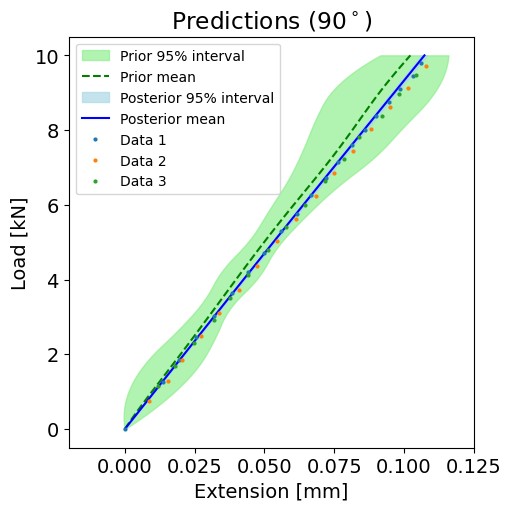

In [ ]:
# plot prior and posterior together
fig_all, ax_all = plt.subplots(figsize=(5,5), layout='constrained')
ax_all.fill_betweenx(samples_load, percentiles_prior[0, :], percentiles_prior[1, :], alpha=0.7, color="lightgreen", label='Prior 95% interval')
ax_all.plot(mean_prediction_prior, samples_load, c="green", ls="dashed", lw=1.5, label='Prior mean')

ax_all.fill_betweenx(samples_load, percentiles_post[0, :], percentiles_post[1, :], alpha=0.7, color="lightblue", label="Posterior 95% interval")
ax_all.plot(mean_prediction_post, samples_load, c="blue", ls="solid", lw=1.5, label="Posterior mean")

sz=2
for i in range(len(input_xy_exp_plt)):
    ax_all.plot(data_exp_plt[i], input_xy_exp_plt[i][:,0], "o", markersize=sz, label='Data '+str(i+1))

ax_all.set(xlabel="Extension [mm]", ylabel="Load [kN]", title="Predictions ($" + str(angle_value) + "^\circ$)")
ax_all.legend(fontsize=10)
if angle_value == 45:
    ax_all.set_xlim(-0.005, 0.09)
if angle_value == 90:
    ax_all.set_xlim(-0.02, 0.125)
if angle_value == 135:
    ax_all.set_xlim(-0.055, 0.09)
fig_all.savefig(fig_path.joinpath("prediction_"+str(angle_value) + "deg_linear_bias_alpha_" + suffix + "." + fig_format), 
                dpi=dpi, transparent=True)
